In [1]:
import os.path as op
import numpy as np
from scipy import stats as stats
from scipy.stats import pearsonr
from functools import partial

import mne
import matplotlib.pyplot as plt
from mne.minimum_norm import make_inverse_operator, apply_inverse, source_band_induced_power, apply_inverse_epochs,compute_source_psd, compute_source_psd_epochs
from mne.datasets import fetch_fsaverage
import pickle
from scipy.stats import sem
from mne import spatial_src_adjacency
from mne.stats import spatio_temporal_cluster_test, summarize_clusters_stc

fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = op.dirname(fs_dir)

# The files live in:
subject = "fsaverage"
trans = "fsaverage"  # MNE has a built-in fsaverage transformation
src_fname = op.join(fs_dir, "bem", "fsaverage-vol-5-src.fif")

src = mne.read_source_spaces(src_fname)

0 files missing from root.txt in C:\Users\malann\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\malann\mne_data\MNE-fsaverage-data\fsaverage
    Reading a source space...
    [done]
    1 source spaces read


In [2]:
pain_rating = {'PASP001':5,'PASP002':6,'PASP003':6,'PASP004':6,'PASP005':8,
               'PASP007':5,'PASP008':5,'PASP010':0,'PASP012':3.5, 'PASP013':4,
               'PASP014':5,'PASP015':3,
               'PASP016':7,'PASP017':3,'PASP020':2.5,
               'PASP021': 7,'PASP022':4,'PASP023':4.5,'PASP025':8, 
               'PASP026':5.5, 'PASP027':5,'PASP028':3,'PASP029':6, 'PASP030':7, 'PASP031':5.5,'PASP032':7,'PASP033': 4.5
               }
len(pain_rating)
  
#'PASP009':6.5,'PASP011':7,'PASP019':7.5,


27

In [3]:
pain_rating.values()

dict_values([5, 6, 6, 6, 8, 5, 5, 0, 3.5, 4, 5, 3, 7, 3, 2.5, 7, 4, 4.5, 8, 5.5, 5, 3, 6, 7, 5.5, 7, 4.5])

In [30]:
Control_list = ["PASC001","PASC003", "PASC004", "PASC005","PASC007","PASC009","PASC010", 
                "PASC011","PASC012", "PASC013",  "PASC015", "PASC018",
                 "PASC019", "PASC020", "PASC022",  "PASC023", "PASC024", "PASC025", 
                "PASC027", "PASC028", "PASC029", "PASC030", "PASC032",
                 "PASC033", "PASC034", "PASC035",  "PASC036", "PASC037", "PASC038", 
                "PASC039", "PASC040", "PASC041"]

Patient_list = ["PASP001", 'PASP002',"PASP003", "PASP004", 'PASP005', "PASP007",  
                "PASP008",'PASP010', 'PASP012', "PASP013", 'PASP014','PASP015', 'PASP016', 
                "PASP017", 'PASP020', 'PASP021',"PASP022", 'PASP023', 'PASP025', 
                'PASP026', 'PASP027', 'PASP028', 'PASP029', 'PASP030', 'PASP031',
                "PASP032",'PASP033', "PASP006", 'PASP018']
#"PASP009", "PASP011", "PASP019", "PASC014",
len(Control_list)

32

In [31]:
len(Control_list)

32

In [32]:
Control_list_MRI = ["PASC004", "PASC007", "PASC032", "PASC036", "PASC041", "PASC028"]

Patient_list_MRI = ["PASP001", "PASP002", "PASP004","PASP014", "PASP017", "PASP019", "PASP020",
                    "PASP021", "PASP022",  "PASP028", "PASP029", "PASP030", "PASP031","PASP033"] # "PASP023",

In [33]:
control_stcs = []
patient_PAF=[]
patient_PAF_power=[]
control_PAF=[]
control_PAF_power=[]
control_stc_all =[]
patient_stc_all = []
control_stcs_raw=[]

avg_stc_control=0
avg_stc_control1=0


nfl, nfh = 1, 80 # cutoff freqs to filter the data 
fl, fh = 8,12 # alpha band in Hz

for sub in Control_list[0:len(Patient_list)]:

    subjects_dir = "E:/Freesurfer_Files"
    
    if sub == "PASC009":
        num = 3
    else:
        num=2


    if sub in Control_list_MRI:
        psd_dir = "E:/Control_Source_Vol_PSDs/"
        fname_stc= f'{psd_dir}{sub}_SPONT_{num}_Vol_psd_dSPM-vl.stc'

    else:
        psd_dir = "E:/Morphed_Control_Source_Vol_PSDs/"
        fname_stc= f'{psd_dir}{sub}_SPONT_{num}_Morph_Vol_psd_dSPM-vl.stc'

    subject = 'fsaverage'    
    
    stc = mne.read_source_estimate(fname_stc)
    stc = stc.copy().crop(nfl, nfh) # using only frequencies between 1 and 80

    # same operation on MNE object, sum across freqs
    # Normalize each source point by the total power across freqs
    
    stc_norm = stc.copy().sum()
    stc = 100 * stc/stc_norm.data
    
    avg_stc_control += stc
    control_stc_all.append(stc)

    stc = stc.copy().crop(fl, fh) 
    avg_stc_control1 += stc
    control_stcs_raw.append(stc)

    control_stcs.append(stc.data)
    source_time_max = (stc.get_peak()[1])
    source_vert_max = (stc.get_peak()[0])
    
    #COG corrected PAF
    source_time_max1 = np.multiply(stc.data,stc.times).sum(axis=1)/stc.data.sum(axis=1) #calculate the PAF for each source
    
    source_vert_max1 = [] #calculate the PAF power for each source
    for i, paf in enumerate(source_time_max1):
        source_vert_max1.append(stc.data[i][np.argmin(np.abs(stc.times - paf))])
         
    control_PAF.append(source_time_max1.mean()) # PAF averaged across all sources
    control_PAF_power.append(np.array(source_vert_max1).mean()) # PAF power averaged across all sources
    


avg_stc_control1 = avg_stc_control1/len(control_stc_all)
avg_stc_control = avg_stc_control/len(control_stc_all)


In [34]:
control_PAF

[9.860742104836946,
 10.12501700765062,
 9.723693778661977,
 9.80764093647581,
 9.764919610893282,
 9.803198056616317,
 9.889516986606383,
 9.887771510880805,
 9.584441597963533,
 10.247184616852365,
 9.921629526871161,
 9.800264777628641,
 9.627729869138694,
 10.081889497671932,
 10.405984452929852,
 9.743248127543804,
 9.789306439416963,
 10.291079771277658,
 10.187622845878098,
 10.296257800607155,
 10.06236760450766,
 9.877102295140219,
 9.868513957280467,
 9.821693601284013,
 9.424223953171351,
 10.05357856659465,
 9.665249643688641,
 10.245679805325658,
 9.90385170415358]

In [35]:
patient_stcs = []
patient_stcs_raw = []
avg_stc_patient = 0
avg_stc_patient1 = 0

for sub in Patient_list:

    subjects_dir = "E:/Freesurfer_Files"

    if sub in Patient_list_MRI:
        psd_dir = "E:/Morphed_Patient_Source_Vol_PSDs/"
        fname_stc= f'{psd_dir}{sub}_SPONT_{num}_Morph_Vol_psd_dSPM-vl.stc'

    else:
        psd_dir = "E:/Patient_Source_Vol_PSDs/"
        fname_stc= f'{psd_dir}{sub}_SPONT_{num}_Vol_psd_dSPM-vl.stc'

    subject = 'fsaverage'
    
    stc = mne.read_source_estimate(fname_stc, subject=subject)
    stc = stc.copy().crop(nfl, nfh) # using only frequencies between 1 and 80

    stc_norm = stc.copy().sum()
    stc = 100 * stc/stc_norm.data
    
    avg_stc_patient += stc
    patient_stc_all.append(stc)
  
    #stc_norm = stc.copy().crop(fl, fh).data.max()  # same operation on MNE object, sum across freqs
    # Normalize each source point by the total power across freqs
    stc = stc.copy().crop(fl, fh)
    
    avg_stc_patient1 += stc    
    patient_stcs_raw.append(stc)
    patient_stcs.append(stc.data)
       
    source_time_max = (stc.get_peak()[1])
    source_vert_max = (stc.get_peak()[0])
    
    #COG corrected PAF
    source_time_max1 = np.multiply(stc.data,stc.times).sum(axis=1)/stc.data.sum(axis=1) #calculate the PAF for each source
    
    source_vert_max1 = [] #calculate the PAF power for each source
    for i, paf in enumerate(source_time_max1):
        source_vert_max1.append(stc.data[i][np.argmin(np.abs(stc.times - paf))])
         
    patient_PAF.append(source_time_max1.mean()) # PAF averaged across all sources
    patient_PAF_power.append(np.array(source_vert_max1).mean()) # PAF power averaged across all sources
    

avg_stc_patient1 = avg_stc_patient1/len(patient_stc_all)
avg_stc_patient = avg_stc_patient/len(patient_stc_all)

Fixing initial time: 9.922806911984422 s
Showing: t = 9.918 s, (0.0, -65.0, 20.0) mm, [16, 10, 19] vox, 24799 vertex


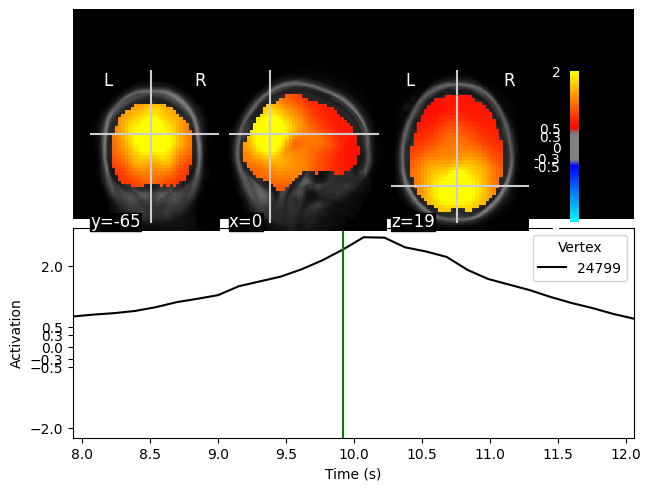

Fixing initial time: 9.781507392333076 s
Showing: t = 9.766 s, (10.0, -75.0, 10.0) mm, [18, 8, 17] vox, 22161 vertex


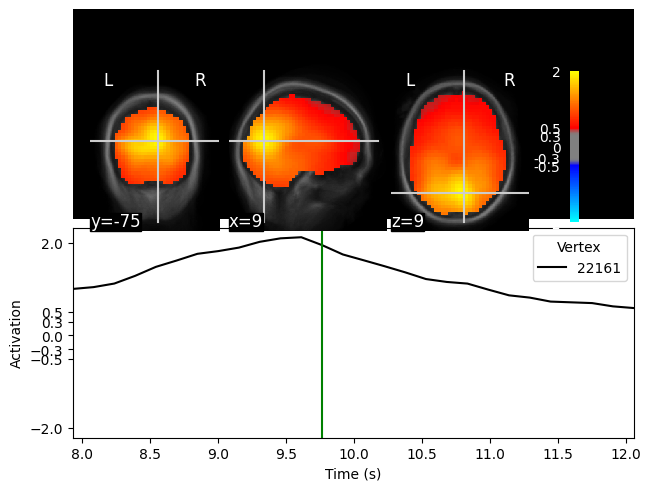

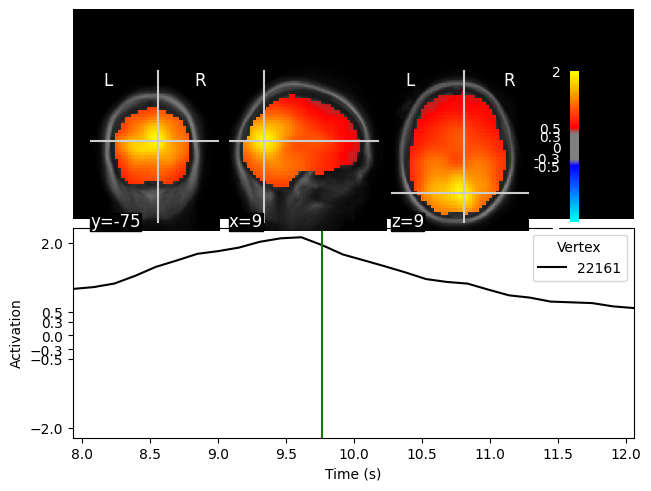

In [42]:
lims = [0.3, 0.5, 2]
kwargs = dict(
    src=src,
    subject=subject,
    subjects_dir=subjects_dir,
    initial_time=np.array(control_PAF).mean(),
    verbose=True,
)
avg_stc_control1.plot(mode="stat_map", clim=dict(kind="value", pos_lims=lims), **kwargs)
kwargs = dict(
    src=src,
    subject=subject,
    subjects_dir=subjects_dir,
    initial_time=np.array(patient_PAF).mean(),
    verbose=True,
)
avg_stc_patient1.plot(mode="stat_map", clim=dict(kind="value", pos_lims=lims), **kwargs)



Fixing initial time: 9.922806911984422 s
Showing: t = 9.918 s, (0.0, -65.0, 20.0) mm, [16, 10, 19] vox, 24799 vertex


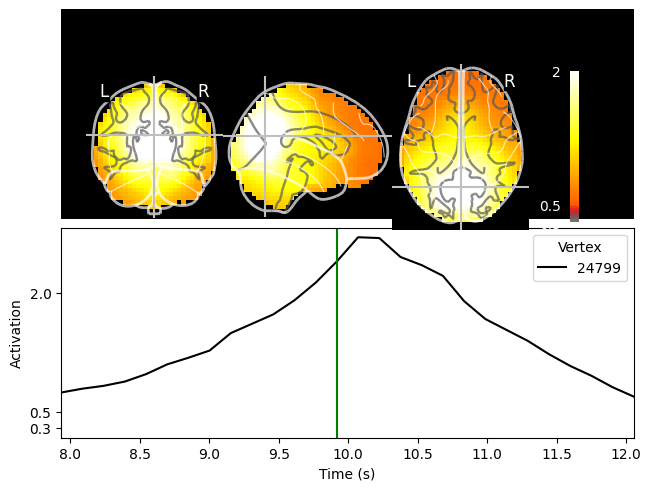

Fixing initial time: 9.781507392333076 s
Showing: t = 9.766 s, (10.0, -75.0, 10.0) mm, [18, 8, 17] vox, 22161 vertex


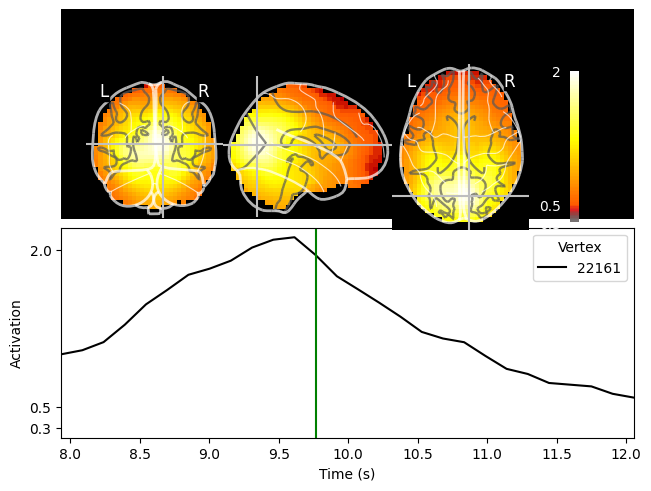

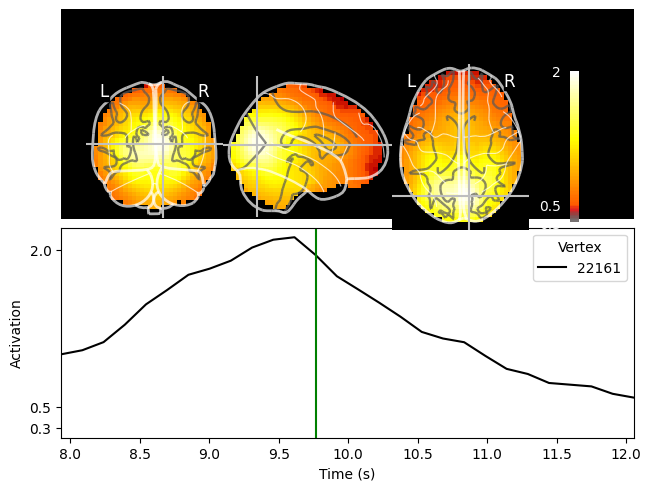

In [44]:
kwargs = dict(
    src=src,
    subject=subject,
    subjects_dir=subjects_dir,
    initial_time=np.array(control_PAF).mean(),
    verbose=True,
)
avg_stc_control1.plot(mode="glass_brain", clim=dict(kind="value", lims=lims), **kwargs)
kwargs = dict(
    src=src,
    subject=subject,
    subjects_dir=subjects_dir,
    initial_time=np.array(patient_PAF).mean(),
    verbose=True,
)
avg_stc_patient1.plot(mode="glass_brain", clim=dict(kind="value", lims=lims), **kwargs)


In [39]:
brain = avg_stc_control1.plot_3d(
    clim=dict(kind="value", lims=lims),
    hemi="both",
    size=(600, 600),
    views=["sagittal"],
    # Could do this for a 3-panel figure:
    # view_layout='horizontal', views=['coronal', 'sagittal', 'axial'],
    brain_kwargs=dict(silhouette=True),
    **kwargs,
)

In [ ]:
brain = avg_stc_control1.plot_3d(
    hemi="both",
    size=(600, 600),
    views=["sagittal"],
    # Could do this for a 3-panel figure:
    # view_layout='horizontal', views=['coronal', 'sagittal', 'axial'],
    brain_kwargs=dict(silhouette=True),
    **kwargs,
)

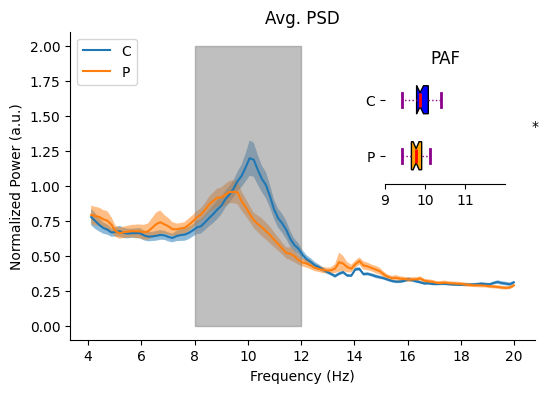

In [40]:
f1, f2 = 4,20 # freqs to plot
freq = avg_stc_control.copy().crop(f1, f2).times

c_sub_avg =[]
for stc in control_stc_all:
    c_sub_avg.append(stc.copy().crop(f1, f2).data.mean(axis = 0))
c_sub_avg = np.array(c_sub_avg)

p_sub_avg =[]
for stc in patient_stc_all:
    p_sub_avg.append(stc.copy().crop(f1, f2).data.mean(axis = 0))
p_sub_avg = np.array(p_sub_avg)

mean_control = np.mean(c_sub_avg,axis=0)
var_control = sem(c_sub_avg,axis=0)

mean_patient = np.mean(p_sub_avg,axis=0)
var_patient = sem(p_sub_avg,axis=0)

fig, ax1 = plt.subplots(figsize=(6, 4))

ax1.plot(freq, mean_control)
ax1.plot(freq, mean_patient)

#ax1.errorbar(freq, mean_control,yerr=var_control,errorevery=(8, 5), capsize=3, capthick=1)
#ax1.errorbar(freq, mean_patient,yerr=var_patient,errorevery=(8, 5), capsize=3, capthick=1)

ax1.fill_between(freq,mean_control+var_control, mean_control-var_control,alpha=0.5)
ax1.fill_between(freq,mean_patient+var_patient, mean_patient-var_patient,alpha=0.5)

ax1.legend(('C', 'P'),
               loc='upper left')

ax1.set_title('Avg. PSD')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Normalized Power (a.u.)')    
ax1.fill_betweenx(range(3), 12,8,color='gray', alpha=0.5)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)

l, b, h, w = .65, .5, .2, .28
ax2 = fig.add_axes([l, b, h, w])
bp = ax2.boxplot([patient_PAF,control_PAF],patch_artist = True,widths =0.5,
                notch ='False', vert = 0)

colors = ['orange','blue']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1,
                linestyle =":")
# changing color and linewidth of
# caps
for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 2)
    
# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='red',
               linewidth = 2)
# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)
ax2.set_yticklabels(['P','C'])
ax2.set_xlim(9, 12)
ax2.set_title('PAF')
ax2.set_xticks([9, 10, 11])

x1, x2 =  12.1, 12.4
y, h, col = 1, 1, 'k'

ax2.plot([x1, x2, x2, x1], [y, y, y+h, y+h], lw=1.5, c=col)

[st, pval] = stats.ttest_ind(patient_PAF,control_PAF) # paired t test between control and patient PAF

if pval<0.05:
    ax2.text((x1+x2)*.52, 1.4, f"*", ha='center', va='bottom', color=col)

    
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(False)
    

#ax2.text((x1+x2)*.52, 1.4, f"* (p={round(pval,3)})", ha='center', va='bottom', color=col)
    
    
plt.show()

In [ ]:
n_vertices_fsave, n_times = stc.data.shape
n_subjects1 = len(control_stcs)
n_subjects2 = len(patient_stcs)
tstep = stc.tstep  # time is frequency here since we have source power in stc

X1 = np.array(control_stcs)
X2 = np.array(patient_stcs)

X1 = np.abs(X1)  # only magnitude
X2 = np.abs(X2)  # only magnitude

#    Note that X needs to be a list of multi-dimensional array of shape
#    samples (subjects_k) × time × space, so we permute dimensions

X1 = np.transpose(X1, [0, 2, 1])
X2 = np.transpose(X2, [0, 2, 1])
X = [X1, X2]

In [ ]:
X1.shape

In [ ]:
from scipy import stats as stats

print("Computing adjacency.")
adjacency = spatial_src_adjacency(src)

# Now let's actually do the clustering. This can take a long time...
# Here we set the threshold quite high to reduce computation,
# and use a very low number of permutations for the same reason.

n_permutations = 1000
p_threshold = 0.001

stat_fun = partial(mne.stats.ttest_ind_no_p, sigma=1e-3)

t_threshold = -stats.distributions.t.ppf(p_threshold / 2., n_subjects1 - 1)

print("Clustering.")
t_obs, clusters, cluster_p_values, H0 = clu = mne.stats.permutation_cluster_test(
    X,
    adjacency=adjacency,
    stat_fun=stat_fun,
    n_jobs=None,
    threshold=t_threshold,
    n_permutations=n_permutations,
    step_down_p=0.05, 
    verbose=True,
    buffer_size=None
)


#    Now select the clusters that are sig. at p < 0.05 (note that this value
#    is multiple-comparisons corrected).
good_cluster_inds = np.where(cluster_p_values < 0.05)[0]


In [ ]:
print("Visualizing clusters.")

#    Now let's build a convenient representation of each cluster, where each
#    cluster becomes a "time point" in the SourceEstimate
fsave_vertices = [np.arange(10242), np.arange(10242)]
stc_all_cluster_vis = summarize_clusters_stc(
    clu,  p_thresh=0.05, tstep=tstep, vertices=fsave_vertices, subject="fsaverage"
)

#    Let's actually plot the first "time point" in the SourceEstimate, which
#    shows all the clusters, weighted by duration

#stc_all_cluster_vis.save('stat_file')

# blue blobs are for condition A != condition B
brain = stc_all_cluster_vis.plot(
    "fsaverage",
    hemi="both",
    views="dorsal",
    subjects_dir=subjects_dir,
    initial_time=0,
    background="w",

    time_label="temporal extent (ms)",
)
brain.add_annotation("aparc", borders=2)

In [ ]:
stc_all_cluster_vis

# Load stats results from HPC

In [45]:
stc_all_cluster_vis = mne.read_source_estimate('stat_file_001_10000_sub_vol_29-vl.stc')

Fixing initial time: 0.0 s
Showing: t = 0.000 s, (-15.0, -45.0, 75.0) mm, [13, 14, 30] vox, 39085 vertex


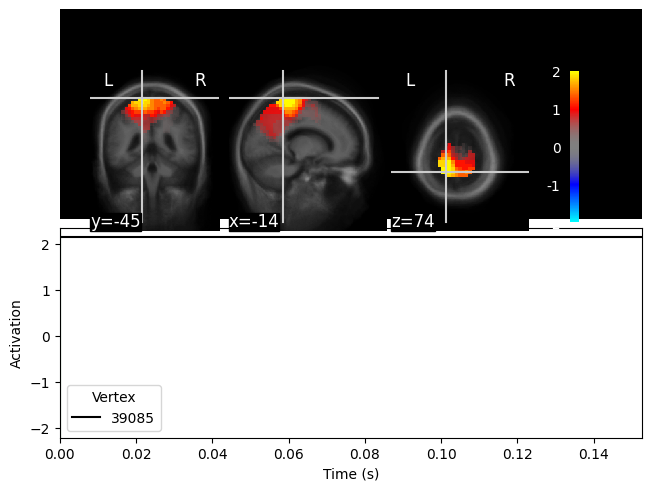

Fixing initial time: 0.0 s
Showing: t = 0.000 s, (-15.0, -45.0, 75.0) mm, [13, 14, 30] vox, 39085 vertex


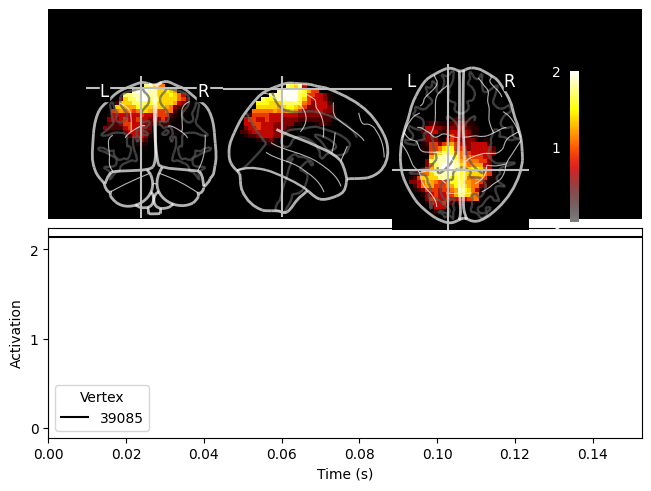

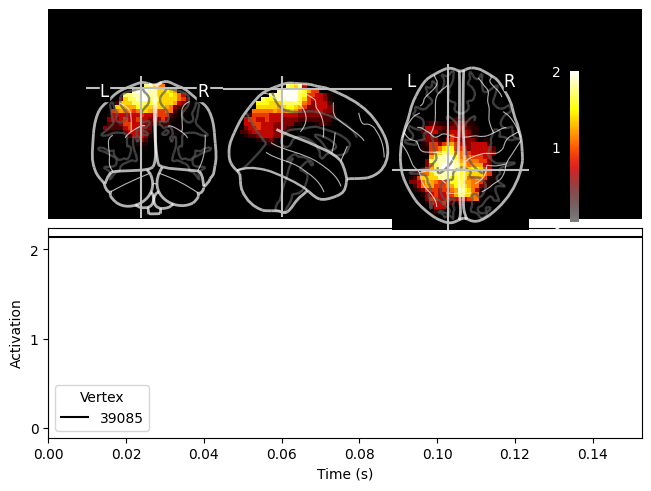

In [49]:
lims = [0, 1, 2]
kwargs = dict(
    src=src,
    subject=subject,
    subjects_dir=subjects_dir,
    initial_time=0,
    verbose=True,
)
stc_all_cluster_vis.plot(mode="stat_map", clim=dict(kind="value", pos_lims=lims), **kwargs)
stc_all_cluster_vis.plot(mode="glass_brain", clim=dict(kind="value", lims=lims), **kwargs)

In [51]:
brain = stc_all_cluster_vis.plot_3d(
    clim=dict(kind="value", lims=lims),
    hemi="both",
    size=(600, 600),
    views=["sagittal"],
    # Could do this for a 3-panel figure:
    # view_layout='horizontal', views=['coronal', 'sagittal', 'axial'],
    brain_kwargs=dict(silhouette=True),
    **kwargs,
)

In [ ]:
# blue blobs are for condition A != condition B
brain = stc_all_cluster_vis.plot(
    "fsaverage",
    hemi="both",
    views="dorsal",
    subjects_dir=subjects_dir,
    initial_time=0,
    background="w",
    time_label="temporal extent (ms)",
)
brain.add_annotation("aparc", borders=2)

In [ ]:
vertno_max, time_max = avg_stc_control1.get_peak()

surfer_kwargs = dict(
    surface = 'inflated',
    hemi="both",
    subjects_dir=subjects_dir,
    clim=dict(kind="value", lims=[0, 0.5, 2]),
    background="w",
    views="dorsal",
    initial_time=time_max,
    time_unit="s",
    size=(800, 800),
    smoothing_steps=10,
)
brain = avg_stc_control1.mean().plot(**surfer_kwargs)
brain.add_foci(
    vertno_max,
    coords_as_verts=True,
    hemi="rh",
    color="blue",
    scale_factor=0.6,
    alpha=0.5,
)
brain.add_text(
    0.1, 0.9, "dSPM (Controls)", "title", font_size=14
)
brain.add_annotation("aparc", borders=2)

In [ ]:
vertno_max, time_max = avg_stc_patient1.get_peak()

surfer_kwargs = dict(
    surface = 'inflated',
    hemi="both",
    subjects_dir=subjects_dir,
    clim=dict(kind="value", lims=[0, 0.5, 2]),
    background="w",
    views="dorsal",
    initial_time=time_max,
    time_unit="s",
    size=(800, 800),
    smoothing_steps=10,
)
brain = avg_stc_patient1.mean().plot(**surfer_kwargs)
brain.add_foci(
    vertno_max,
    coords_as_verts=True,
    hemi="rh",
    color="blue",
    scale_factor=0.6,
    alpha=0.5,
)
brain.add_text(
    0.1, 0.9, "dSPM (Patients)", "title", font_size=14
)
brain.add_annotation("aparc", borders=2)

Finding which areas are different

In [ ]:
subjects_dir = "E:/Freesurfer_Files"

labels = mne.read_labels_from_annot(
        "fsaverage", "aparc", "both", subjects_dir=subjects_dir
    )
labels = labels[:-1]

sp_areas = [ labels[24],labels[25],labels[28],labels[29]]
sp_areas

In [ ]:
Avg_stc_in_label = []
stcs_in_label = []
vertno_max_in_label = []
time_max_in_label = []
max_in_label = []

for lbl in labels:
    lbl_name = lbl.name
    stcs_in_label.append(stc_all_cluster_vis.in_label(lbl))
    Avg_stc_in_label.append(stc_all_cluster_vis.in_label(lbl).data)
    
    max_in_label.append(stc_all_cluster_vis.in_label(lbl).data.mean(axis = 0).mean())
    
good_area=[]
good_labels = []

for n in range(len(Avg_stc_in_label)):
    if Avg_stc_in_label[n].max()>0.91:
        #print(Avg_stc_in_label[n].max())
        good_area.append(stcs_in_label[n])
        good_labels.append(labels[n])
        
#indx = [3,5,6]

#good_labels = [good_labels[i] for i in indx]
#good_area = [good_area[i] for i in indx]

In [ ]:
good_labels[2]

In [ ]:
good_labels

In [ ]:
# blue blobs are for condition A != condition B
brain = good_area[2].plot(
    "fsaverage",
    hemi="both",
    views="dorsal",
    subjects_dir=subjects_dir,
    initial_time=0,
    background="w",
    time_label="temporal extent (ms)",
    
)
brain.add_annotation("aparc", borders=2)

In [ ]:
f1, f2 = 4,20 # freqs to plot
freq = avg_stc_control.copy().crop(f1, f2).times

c_sub_avg =[]
for stc in control_stc_all:
    c_sub_avg.append(stc.copy().crop(f1, f2).data.mean(axis = 0))
c_sub_avg = np.array(c_sub_avg)

p_sub_avg =[]
for stc in patient_stc_all:
    p_sub_avg.append(stc.copy().crop(f1, f2).data.mean(axis = 0))
p_sub_avg = np.array(p_sub_avg)

mean_control = np.mean(c_sub_avg,axis=0)
var_control = sem(c_sub_avg,axis=0)

mean_patient = np.mean(p_sub_avg,axis=0)
var_patient = sem(p_sub_avg,axis=0)

fig, ax1 = plt.subplots(figsize=(6, 4))

ax1.plot(freq, mean_control)
ax1.plot(freq, mean_patient)

In [ ]:
sub = 'PASC004'
psd_dir = "E:/Patient_Source_Vol_PSDs/"
psd_dir = "E:/Control_Source_Vol_PSDs/"

fname_stc= psd_dir+sub+"_SPONT_2_Vol_psd_dSPM-vl.stc"
f1, f2 = 4, 20

subject = 'fsaverage'

stc = mne.read_source_estimate(fname_stc, subject=subject)
stc_norm = stc.copy().sum()
stc = 100 * stc/stc_norm.data
freq = stc.copy().crop(f1, f2).times

plt.plot(freq, stc.copy().crop(f1, f2).data.mean(axis=0),freq, avg_stc_control.copy().crop(f1, f2).data.mean(axis = 0),freq ,avg_stc_patient.copy().crop(f1, f2).data.mean(axis = 0))
plt.legend((sub,'Control', 'Patient'),
               loc='upper right')
plt.title('PSD')
plt.show()

In [ ]:
plot_area = 'sig_area'

if plot_area =='sig_area':
    good_labels = good_labels
elif plot_area =='spec_area':
    good_labels = sp__labels


C_stcs_all = []
PAF_C_all = []
PAF_C_power_all=[]
for stc1 in control_stc_all:   
    C_stcs = []
    PAF_C=[]
    PAF_C_power=[]
    
    for lbl in good_labels:
        stc = stc1.copy().crop(f1, f2)
        C_stcs.append(stc.in_label(lbl))
        
        stc=stc1.copy().in_label(lbl).crop(fl, fh)
        
        # direct PAF method
        #PAF_C.append((stc.in_label(lbl).crop(fl, fh).get_peak()[1]))
        #PAF_C_power.append(stc.in_label(lbl).crop(fl, fh).data.max())
        
        #COG corrected PAF
        source_time_max1 = np.multiply(stc.data,stc.times).sum(axis=1)/stc.data.sum(axis=1) #calculate the PAF for each source

        source_vert_max1 = [] #calculate the PAF power for each source
        for i, paf in enumerate(source_time_max1):
            source_vert_max1.append(stc.data[i][np.argmin(np.abs(stc.times - paf))])

        PAF_C.append(source_time_max1.mean()) # PAF averaged across all sources
        PAF_C_power.append(np.array(source_vert_max1).mean()) # PAF power averaged across all sources
        
        
        
        
    C_stcs_all.append(C_stcs)
    PAF_C_all.append(PAF_C)
    PAF_C_power_all.append(PAF_C_power)
    
P_stcs_all = []
PAF_P_all = []
PAF_P_power_all=[]
for stc2 in patient_stc_all:
    P_stcs = []
    PAF_P=[]
    PAF_P_power=[]
    for lbl in good_labels:
        stc = stc2.copy().crop(f1, f2)
        P_stcs.append(stc.in_label(lbl))
        
        # direct  paf method
        #PAF_P.append((stc.in_label(lbl).crop(fl, fh).get_peak()[1]))
        #PAF_P_power.append(stc.in_label(lbl).crop(fl, fh).data.max())
        
        
        #COG corrected PAF
        
        stc=stc2.copy().in_label(lbl).crop(fl, fh)

        source_time_max1 = np.multiply(stc.data,stc.times).sum(axis=1)/stc.data.sum(axis=1) #calculate the PAF for each source

        source_vert_max1 = [] #calculate the PAF power for each source
        for i, paf in enumerate(source_time_max1):
            source_vert_max1.append(stc.data[i][np.argmin(np.abs(stc.times - paf))])

        PAF_P.append(source_time_max1.mean()) # PAF averaged across all sources
        PAF_P_power.append(np.array(source_vert_max1).mean()) # PAF power averaged across all sources

        

    P_stcs_all.append(P_stcs)
    PAF_P_all.append(PAF_P)
    PAF_P_power_all.append(PAF_P_power)

C_stcs_all = np.array(C_stcs_all).T
PAF_C_all = np.array(PAF_C_all).T
PAF_C_power_all = np.array(PAF_C_power_all).T
P_stcs_all = np.array(P_stcs_all).T
PAF_P_all = np.array(PAF_P_all).T
PAF_P_power_all = np.array(PAF_P_power_all).T

In [ ]:
fig, ax1 = plt.subplots(2,int(len(good_labels)/2), figsize=(24, 8))
ax1 = ax1.ravel()

for n in range(len(good_labels)):
    
    c_sub_avg =[]
    for stc in C_stcs_all[n]:
        c_sub_avg.append(stc.copy().crop(f1, f2).data.mean(axis = 0))
    c_sub_avg = np.array(c_sub_avg)

    p_sub_avg =[]
    for stc in P_stcs_all[n]:
        p_sub_avg.append(stc.copy().crop(f1, f2).data.mean(axis = 0))
    p_sub_avg = np.array(p_sub_avg)

    
    mean_control = np.mean(c_sub_avg,axis=0)
    var_control = sem(c_sub_avg,axis=0)

    mean_patient = np.mean(p_sub_avg,axis=0)
    var_patient = sem(p_sub_avg,axis=0)
    
   
    freq = avg_stc_control.copy().crop(f1, f2).times
    
    ax1[n].plot(freq, mean_control)
    ax1[n].plot(freq, mean_patient)

    ax1[n].fill_between(freq,mean_control+var_control, mean_control-var_control,alpha=0.5)
    ax1[n].fill_between(freq,mean_patient+var_patient, mean_patient-var_patient,alpha=0.5)

    ax1[n].legend(('C', 'P'),
               loc='upper left', fontsize="10")
    ax1[n].set_title(good_labels[n].name, fontsize=18)
    ax1[n].set_xlabel('Frequency (Hz)',fontsize=14)
    ax1[n].set_ylabel("Normalized Power (a.u.)",fontsize=14)
    ax1[n].fill_betweenx(range(4), 12,8,color='skyblue', alpha=0.5) 
    
    ax1[n].spines['top'].set_visible(False)
    ax1[n].spines['right'].set_visible(False)
    ax1[n].spines['bottom'].set_visible(True)
    ax1[n].spines['left'].set_visible(True)
    
    
    l, b, h, w = .65, .5, .3, .28
    
    ax2 = ax1[n].inset_axes([l, b, h, w])
    
    
    bp = ax2.boxplot([PAF_P_all[n],PAF_C_all[n]],patch_artist = True,widths =0.5,
                notch ='False', vert = 0)
   
    colors = ['orange','blue']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    # changing color and linewidth of
    # whiskers
    for whisker in bp['whiskers']:
        whisker.set(color ='#8B008B',
                    linewidth = 1,
                    linestyle =":")
    # changing color and linewidth of
    # caps
    for cap in bp['caps']:
        cap.set(color ='#8B008B',
                linewidth = 2)

    # changing color and linewidth of
    # medians
    for median in bp['medians']:
        median.set(color ='red',
                   linewidth = 2)
    # changing style of fliers
    for flier in bp['fliers']:
        flier.set(marker ='D',
                  color ='#e7298a',
                  alpha = 0.5)
    ax2.set_yticklabels(['P','C'])
    ax2.set_xlim(8, 12)
    ax2.set_title('PAF')
    ax2.set_xticks([8, 9, 10, 11])

    x1, x2 =  12.1, 12.4
    y, h, col = 1, 1, 'k'

    ax2.plot([x1, x2, x2, x1], [y, y, y+h, y+h], lw=1.5, c=col)
    
    [st, pval] = stats.ttest_ind(PAF_P_all[n],PAF_C_all[n]) # paired t test between control and patient PAF

    if pval<0.05:
        ax2.text((x1+x2)*.52, 1.4, f"*", ha='center', va='bottom', color=col)    
       
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(True)
    ax2.spines['left'].set_visible(False)
    
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.4)
plt.show()

In [ ]:
# For specific area

C_stcs_all = []
PAF_C_all = []
PAF_C_power_all=[]
for stc in control_stc_all:   
    C_stcs = []
    PAF_C=[]
    PAF_C_power=[]
    
    for lbl in sp_ares:
        stc = stc.copy().crop(f1, f2)
        C_stcs.append(stc.in_label(lbl))
        PAF_C.append((stc.in_label(lbl).crop(fl, fh).get_peak()[1]))
        PAF_C_power.append(stc.in_label(lbl).crop(fl, fh).data.max())

    C_stcs_all.append(C_stcs)
    PAF_C_all.append(PAF_C)
    PAF_C_power_all.append(PAF_C_power)
    
P_stcs_all = []
PAF_P_all = []
PAF_P_power_all=[]
for stc in patient_stc_all:
    P_stcs = []
    PAF_P=[]
    PAF_P_power=[]
    for lbl in sp_ares:
        stc = stc.copy().crop(f1, f2)
        P_stcs.append(stc.in_label(lbl))
        PAF_P.append((stc.in_label(lbl).crop(fl, fh).get_peak()[1]))
        PAF_P_power.append(stc.in_label(lbl).crop(fl, fh).data.max())

    P_stcs_all.append(P_stcs)
    PAF_P_all.append(PAF_P)
    PAF_P_power_all.append(PAF_P_power)

C_stcs_all = np.array(C_stcs_all).T
PAF_C_all = np.array(PAF_C_all).T
PAF_C_power_all = np.array(PAF_C_power_all).T
P_stcs_all = np.array(P_stcs_all).T
PAF_P_all = np.array(PAF_P_all).T
PAF_P_power_all = np.array(PAF_P_power_all).T

In [ ]:
fig, ax1 = plt.subplots(2,int(len(sp_areas)/2), figsize=(12, 8))
ax1 = ax1.ravel()

for n in range(len(sp_areas)):
    
    c_sub_avg =[]
    for stc in C_stcs_all[n]:
        c_sub_avg.append(stc.copy().crop(f1, f2).data.mean(axis = 0))
    c_sub_avg = np.array(c_sub_avg)

    p_sub_avg =[]
    for stc in P_stcs_all[n]:
        p_sub_avg.append(stc.copy().crop(f1, f2).data.mean(axis = 0))
    p_sub_avg = np.array(p_sub_avg)

    
    mean_control = np.mean(c_sub_avg,axis=0)
    var_control = sem(c_sub_avg,axis=0)

    mean_patient = np.mean(p_sub_avg,axis=0)
    var_patient = sem(p_sub_avg,axis=0)
    
   
    freq = avg_stc_control.copy().crop(f1, f2).times
    
    ax1[n].plot(freq, mean_control)
    ax1[n].plot(freq, mean_patient)

    ax1[n].fill_between(freq,mean_control+var_control, mean_control-var_control,alpha=0.5)
    ax1[n].fill_between(freq,mean_patient+var_patient, mean_patient-var_patient,alpha=0.5)

    ax1[n].legend(('C', 'P'),
               loc='upper left', fontsize="10")
    ax1[n].set_title(sp_ares[n].name, fontsize=18)
    ax1[n].set_xlabel('Frequency (Hz)',fontsize=14)
    ax1[n].set_ylabel("Normalized Power (a.u.)",fontsize=14)
    ax1[n].fill_betweenx(range(3), 12,8,color='skyblue', alpha=0.5) 
    
    ax1[n].spines['top'].set_visible(False)
    ax1[n].spines['right'].set_visible(False)
    ax1[n].spines['bottom'].set_visible(True)
    ax1[n].spines['left'].set_visible(True)
    
       
    
    l, b, h, w = .65, .5, .3, .28
    
    ax2 = ax1[n].inset_axes([l, b, h, w])
    
    
    bp = ax2.boxplot([PAF_P_all[n],PAF_C_all[n]],patch_artist = True,widths =0.5,
                notch ='False', vert = 0)

    [st, pval] = ttest_ind(PAF_P_all[n],PAF_C_all[n]) # paired t test between control and patient PAF
    
    
    colors = ['orange','blue']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    # changing color and linewidth of
    # whiskers
    for whisker in bp['whiskers']:
        whisker.set(color ='#8B008B',
                    linewidth = 1,
                    linestyle =":")
    # changing color and linewidth of
    # caps
    for cap in bp['caps']:
        cap.set(color ='#8B008B',
                linewidth = 2)

    # changing color and linewidth of
    # medians
    for median in bp['medians']:
        median.set(color ='red',
                   linewidth = 2)
    # changing style of fliers
    for flier in bp['fliers']:
        flier.set(marker ='D',
                  color ='#e7298a',
                  alpha = 0.5)
    ax2.set_yticklabels(['P','C'])
    ax2.set_xlim(8, 13)
    ax2.set_title('PAF')
    ax2.set_xticks([8, 9, 10, 11, 12])

    x1, x2 =  12.1, 12.4
    y, h, col = 1, 1, 'k'

    ax2.plot([x1, x2, x2, x1], [y, y, y+h, y+h], lw=1.5, c=col)
    
    if pval<0.05:
        ax2.text((x1+x2)*.52, 1.4, f"*", ha='center', va='bottom', color=col)
        #ax2.text((x1+x2)*.52, 1.4, f"* (p={round(pval,3)})", ha='center', va='bottom', color=col)
    
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(True)
    ax2.spines['left'].set_visible(False)
    
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.4)
plt.show()

# PAF and PAF Power

In [ ]:
PAF_Power_P_all=[]
PAF_P_all=[]
PAF_P_stcs = []
PAF_Power_P_stcs = []
fl, fh = 8,12

sub_with_MRI= ["PASP001", "PASP002", "PASP004","PASP014", "PASP017", "PASP019", 
                "PASP020", "PASP021", "PASP022","PASP023", "PASP028", "PASP029", 
                "PASP030", "PASP031", "PASP033"]

for sub in Patient_list:

    subjects_dir = "E:/Freesurfer_Files"

    if sub in sub_with_MRI:
        psd_dir = "E:/Morphed_Patient_Source_PSDs/"
        fname_stc= psd_dir+sub+"_SPONT_2_Morph_psd_dSPM"

    else:
        psd_dir = "E:/Patient_Source_PSDs/"
        fname_stc= psd_dir+sub+"_SPONT_2_psd_dSPM"

    subject = 'fsaverage'
    
    stc = mne.read_source_estimate(fname_stc, subject=subject)
    stc = stc.copy().crop(1, 50)

    stc_norm = stc.copy().sum()
    stc = 100 * stc/stc_norm.data
 
    #stc_norm = stc.copy().crop(fl, fh).data.max()  # same operation on MNE object, sum across freqs
    # Normalize each source point by the total power across freqs
    stc = stc.copy().crop(fl, fh)

    #PAF_Power = stc.data.max(axis=1)
    #PAF_Power = PAF_Power.reshape([PAF_Power.shape[0],1])

    #PAF = stc.times[stc.data.argmax(axis=1)]
    #PAF = PAF.reshape([PAF.shape[0],1])
    
    #COG corrected PAF
    PAF = np.multiply(stc.data,stc.times).sum(axis=1)/stc.data.sum(axis=1) #calculate the PAF for each source

    PAF_Power = [] #calculate the PAF power for each source
    for i, paf in enumerate(PAF):
        PAF_Power.append(stc.data[i][np.argmin(np.abs(stc.times - paf))])

    PAF_Power = np.array(PAF_Power)

    PAF_Power = mne.SourceEstimate(PAF_Power,stc.vertices,tmin=stc.tmin, tstep=stc.tstep,subject="fsaverage")
    PAF = mne.SourceEstimate(PAF,stc.vertices,tmin=stc.tmin, tstep=stc.tstep,subject="fsaverage")
    
    PAF_Power_P_all.append(PAF_Power)
    PAF_P_all.append(PAF)
    PAF_Power_P_stcs.append(PAF_Power.data)
    PAF_P_stcs.append(PAF.data)
PAF_Power_P_stcs = np.rollaxis(np.array(PAF_Power_P_stcs),2,1)
PAF_P_stcs =  np.rollaxis(np.array(PAF_P_stcs),2,1)
    
    #PAF_Power_P.save('E:/GLM_SPM/PAF_Power/'+sub+'_PAF_power',overwrite=True)
    #PAF_P.save('E:/GLM_SPM/PAF/'+sub+'_PAF',overwrite=True)



PAF_Power_C_all=[]
PAF_C_all=[]
PAF_C_stcs = []
PAF_Power_C_stcs = []

for sub in Control_list[0:len(Patient_list)]:

    subjects_dir = "E:/Freesurfer_Files"

    if sub in Control_list_MRI:
        psd_dir = "E:/Control_Source_PSDs/"
        fname_stc= psd_dir+sub+"_SPONT_2_psd_dSPM"

    else:
        psd_dir = "E:/Morphed_Control_Source_PSDs/"
        fname_stc= psd_dir+sub+"_SPONT_2_Morph_psd_dSPM"

    subject = 'fsaverage'
    
    stc = mne.read_source_estimate(fname_stc, subject=subject)
    stc = stc.copy().crop(1, 50)

    stc_norm = stc.copy().sum()
    stc = 100 * stc/stc_norm.data
 
    #stc_norm = stc.copy().crop(fl, fh).data.max()  # same operation on MNE object, sum across freqs
    # Normalize each source point by the total power across freqs
    stc = stc.copy().crop(fl, fh)
    
    #PAF_Power = stc.data.max(axis=1)
    #PAF_Power = PAF_Power.reshape([PAF_Power.shape[0],1])
    
    #PAF = stc.times[stc.data.argmax(axis=1)]
    #PAF = PAF.reshape([PAF.shape[0],1])
    
    #COG corrected PAF
    PAF = np.multiply(stc.data,stc.times).sum(axis=1)/stc.data.sum(axis=1) #calculate the PAF for each source

    PAF_Power = [] #calculate the PAF power for each source
    for i, paf in enumerate(PAF):
        PAF_Power.append(stc.data[i][np.argmin(np.abs(stc.times - paf))])

    PAF_Power = np.array(PAF_Power)
           
    PAF_Power = mne.SourceEstimate(PAF_Power,stc.vertices,tmin=stc.tmin, tstep=stc.tstep,subject="fsaverage")
    PAF = mne.SourceEstimate(PAF,stc.vertices,tmin=stc.tmin, tstep=stc.tstep,subject="fsaverage")
    
    PAF_Power_C_all.append(PAF_Power)
    PAF_C_all.append(PAF)
    PAF_Power_C_stcs.append(PAF_Power.data)
    PAF_C_stcs.append(PAF.data)
    
    PAF_Power.save('E:/GLM_SPM/PAF_Power/'+sub+'_PAF_power',overwrite=True)
    PAF.save('E:/GLM_SPM/PAF/'+sub+'_PAF',overwrite=True)
    
PAF_Power_C_stcs = np.rollaxis(np.array(PAF_Power_C_stcs),2,1)
PAF_C_stcs =  np.rollaxis(np.array(PAF_C_stcs),2,1)

# Read PAF Power

In [ ]:
import pandas as pd
 
     
# list of name, degree, score
nme = lbl_name
     
# dictionary of lists
dict_mne = {'name': nme}
     
df = pd.DataFrame(dict_mne)
     
# saving the dataframe
df.to_csv('output.csv')

In [ ]:
subjects_dir = "E:/Freesurfer_Files"

labels = mne.read_labels_from_annot(
        "fsaverage", "aparc_sub", "both", subjects_dir=subjects_dir
    )
#labels = labels[:-1]

PAF_Power_stc=0
PAF_Power_sub = []
for sub in Control_list:
    subject = 'fsaverage'
    fname = 'E:/GLM_SPM/PAF_Power/'+sub+'_PAF_power'
    PAF_Power = mne.read_source_estimate(fname, subject=subject)
    
    PAF_Power_lbl=[]
    lbl_name=[]
    PAF_Power_stc+=PAF_Power
    
    for lbl in labels:
        lbl_name.append(lbl.name)
        PAF_Power_lbl.append(PAF_Power.in_label(lbl).data.mean())
        
    PAF_Power_sub.append(PAF_Power_lbl)
PAF_Power_sub=np.array(PAF_Power_sub)
PAF_Power_stc = PAF_Power_stc/len(Control_list)

In [ ]:
sp_name=['superiorfrontal_17-rh','inferiorparietal_10-lh','superiorparietal_1-lh','inferiorparietal_2-lh']

sp_name = ['precuneus_1-lh', 'superiorfrontal_17-rh']
sp_areas=[]
for ilbl, lbl in enumerate(labels):
    if lbl.name in sp_name:
        print(lbl.name)
        sp_areas.append(lbl)
       


In [ ]:
surfer_kwargs = dict(
    surface = 'inflated',
    hemi="rh",
    subjects_dir=subjects_dir,
    clim=dict(kind="value", lims=[0, 0.5, 4]),
    background="w",
    views="dorsal",
    initial_time=0,
    time_unit="s",
    size=(800, 800),
    smoothing_steps=10
)
brain = PAF_Power_stc.in_label(sp_areas[1]).plot(**surfer_kwargs)
        

#brain.add_annotation("aparc_sub", borders=1)

In [ ]:
PAF_Power_sub = []
PAF_Power_stc_P = 0

for sub in Patient_list:
    subject = 'fsaverage'
    fname = 'E:/GLM_SPM/PAF_Power/'+sub+'_PAF_power'
    PAF_Power = mne.read_source_estimate(fname, subject=subject)
    
    PAF_Power_lbl=[]
    lbl_name=[]
    PAF_Power_stc_P+=PAF_Power
    
    for lbl in labels:
        lbl_name.append(lbl.name)
        PAF_Power_lbl.append(PAF_Power.in_label(lbl).data.mean())
        
    PAF_Power_sub.append(PAF_Power_lbl)
PAF_Power_sub=np.array(PAF_Power_sub)

PAF_Power_stc_P =PAF_Power_stc_P/len(Patient_list)

In [ ]:
surfer_kwargs = dict(
    surface = 'inflated',
    hemi="rh",
    subjects_dir=subjects_dir,
    clim=dict(kind="value", lims=[0, 0.5, 4]),
    background="w",
    views="dorsal",
    initial_time=0,
    time_unit="s",
    size=(800, 800),
    smoothing_steps=10
)

brain = PAF_Power_stc_P.in_label(sp_areas[1]).plot(**surfer_kwargs)
        

In [ ]:
PAF_Power_sub.shape

In [ ]:
np.savetxt("PAF_pwer.csv", PAF_Power_sub, delimiter=",")


In [ ]:
# For specific area

PAF_C_power_all=[]
for stc in PAF_Power_C_all:   
    PAF_C_power=[]
    
    for lbl in sp_areas:
        PAF_C_power.append(stc.in_label(lbl).data.mean())
        
    PAF_C_power_all.append(PAF_C_power)
PAF_C_power_all=np.array(PAF_C_power_all)

In [ ]:
PAF_C_power_all.shape

In [ ]:
PAF_C_power_all

np.savetxt("foo.csv", PAF_C_power_all, delimiter=",")



# Stats for PAF Power

In [ ]:
n_vertices_fsave, n_times = stc.data.shape
n_subjects1 = len(PAF_Power_C_stcs)
n_subjects2 = len(PAF_Power_P_stcs)
tstep = stc.tstep  # time is frequency here since we have source power in stc

X1 = np.array(PAF_Power_C_stcs)
X2 = np.array(PAF_Power_P_stcs)

X1 = np.abs(X1)  # only magnitude
X2 = np.abs(X2)  # only magnitude

#    Note that X needs to be a list of multi-dimensional array of shape
#    samples (subjects_k) × time × space, so we permute dimensions

X1 = np.transpose(X1, [0, 2, 1])
X2 = np.transpose(X2, [0, 2, 1])
X = [X1, X2]
X1.shape

In [ ]:
from scipy import stats as stats

print("Computing adjacency.")
adjacency = spatial_src_adjacency(src)

# Now let's actually do the clustering. This can take a long time...
# Here we set the threshold quite high to reduce computation,
# and use a very low number of permutations for the same reason.

n_permutations = 1000
p_threshold = 0.05

stat_fun = partial(mne.stats.ttest_ind_no_p, sigma=1e-3)

t_threshold = -stats.distributions.t.ppf(p_threshold / 2., n_subjects1 - 1)

print("Clustering.")
t_obs, clusters, cluster_p_values, H0 = clu = mne.stats.permutation_cluster_test(
    X,
    adjacency=adjacency,
    stat_fun=stat_fun,
    n_jobs=None,
    threshold=t_threshold,
    n_permutations=n_permutations,
    step_down_p=0.05, 
    verbose=True,
    buffer_size=None
)


#    Now select the clusters that are sig. at p < 0.05 (note that this value
#    is multiple-comparisons corrected).
good_cluster_inds = np.where(cluster_p_values < 0.05)[0]


# Load stats results from HPC for PAF Power

In [ ]:
with open('stat_file_05_10000_sub_PAF_Power_29.pickle', 'rb') as f:
     clu = pickle.load(f)
        
t_obs, clusters, cluster_p_values, H0 = clu
signs = np.sign(X1[0]-X2[0])
F_obs_plot = np.nan * np.ones_like(t_obs)

for c, p_val in zip(clusters, cluster_p_values):
    if p_val <= 0.05:
        F_obs_plot[c] = t_obs[c] * signs[c]
        
F_obs_plot= np.nan_to_num(F_obs_plot, copy=True, nan=0.0)

F_obs_plot = mne.SourceEstimate(F_obs_plot,stc.vertices,tmin=stc.tmin, tstep=stc.tstep,subject="fsaverage")


In [ ]:
brain = F_obs_plot.plot(
    "fsaverage",
    hemi="both",
    views="dorsal",
    subjects_dir=subjects_dir,
    initial_time=0,
    background="w",
    time_label="temporal extent (ms)",
    clim=dict(kind="value", lims=[0.7, 3, 6]),    
)
brain.add_annotation("aparc", borders=2)

# Stats for PAF 

In [ ]:
n_vertices_fsave, n_times = stc.data.shape
n_subjects1 = len(PAF_C_stcs)
n_subjects2 = len(PAF_P_stcs)
tstep = stc.tstep  # time is frequency here since we have source power in stc

X1 = np.array(PAF_C_stcs)
X2 = np.array(PAF_P_stcs)

X1 = np.abs(X1)  # only magnitude
X2 = np.abs(X2)  # only magnitude

#    Note that X needs to be a list of multi-dimensional array of shape
#    samples (subjects_k) × time × space, so we permute dimensions

X1 = np.transpose(X1, [0, 2, 1])
X2 = np.transpose(X2, [0, 2, 1])
X = [X1, X2]
X1.shape

In [ ]:
from scipy import stats as stats

print("Computing adjacency.")
adjacency = spatial_src_adjacency(src)

# Now let's actually do the clustering. This can take a long time...
# Here we set the threshold quite high to reduce computation,
# and use a very low number of permutations for the same reason.

n_permutations = 1000
p_threshold = 0.05

stat_fun = partial(mne.stats.ttest_ind_no_p, sigma=1e-3)

t_threshold = -stats.distributions.t.ppf(p_threshold / 2., n_subjects1 - 1)

print("Clustering.")
t_obs, clusters, cluster_p_values, H0 = clu = mne.stats.permutation_cluster_test(
    X,
    adjacency=adjacency,
    stat_fun=stat_fun,
    n_jobs=None,
    threshold=t_threshold,
    n_permutations=n_permutations,
    step_down_p=0.05, 
    verbose=True,
    buffer_size=None
)


#    Now select the clusters that are sig. at p < 0.05 (note that this value
#    is multiple-comparisons corrected).
good_cluster_inds = np.where(cluster_p_values < 0.05)[0]


In [ ]:
stc

# Load stats results from HPC for PAF

In [ ]:
with open('stat_file_05_10000_sub_PAF_29.pickle', 'rb') as f:
     clu = pickle.load(f)

t_obs, clusters, cluster_p_values, H0 = clu
signs = np.sign(X1[0]-X2[0])
F_obs_plot = np.nan * np.ones_like(t_obs)

for c, p_val in zip(clusters, cluster_p_values):
    if p_val <= 0.05:
        F_obs_plot[c] = t_obs[c] * signs[c]
        
F_obs_plot= np.nan_to_num(F_obs_plot, copy=True, nan=0.0)

F_obs_plot = mne.SourceEstimate(F_obs_plot,stc.vertices,tmin=stc.tmin, tstep=stc.tstep,subject="fsaverage")


In [ ]:
brain = F_obs_plot.plot(
    "fsaverage",
    hemi="both",
    views="dorsal",
    subjects_dir=subjects_dir,
    initial_time=0,
    background="w",
    time_label="temporal extent (ms)",
    clim=dict(kind="value", lims=[0.7, 3, 6]),    
)
brain.add_annotation("aparc", borders=2)

Clinical Correlation

In [ ]:
fl, fh=8,12

C_stcs_all = []
PAF_C_all = []
PAF_C_power_all=[]
for stc in control_stc_all:   
    C_stcs = []
    PAF_C=[]
    PAF_C_power=[]
    
    for lbl in labels:
        stc = stc.copy().crop(f1, f2)
        C_stcs.append(stc.in_label(lbl))
        PAF_C.append((stc.in_label(lbl).crop(fl, fh).get_peak()[1]))
        PAF_C_power.append(stc.in_label(lbl).crop(fl, fh).data.max())

    C_stcs_all.append(C_stcs)
    PAF_C_all.append(PAF_C)
    PAF_C_power_all.append(PAF_C_power)
    
P_stcs_all = []
PAF_P_all = []
PAF_P_power_all=[]
for stc in patient_stc_all:
    P_stcs = []
    PAF_P=[]
    PAF_P_power=[]
    for lbl in labels:
        stc = stc.copy().crop(f1, f2)
        P_stcs.append(stc.in_label(lbl))
        PAF_P.append((stc.in_label(lbl).crop(fl, fh).get_peak()[1]))
        PAF_P_power.append(stc.in_label(lbl).crop(fl, fh).data.max())

    P_stcs_all.append(P_stcs)
    PAF_P_all.append(PAF_P)
    PAF_P_power_all.append(PAF_P_power)

C_stcs_all = np.array(C_stcs_all).T
PAF_C_all = np.array(PAF_C_all).T
c = np.array(PAF_C_power_all).T
P_stcs_all = np.array(P_stcs_all).T
PAF_P_all = np.array(PAF_P_all).T
PAF_P_power_all = np.array(PAF_P_power_all).T

In [ ]:
PAF_C_power_all.shape

In [ ]:
pain_power_indx=[]
for n in range(len(labels)):
    stats,p_val = pearsonr(PAF_P_power_all[n][:-2],list(pain_rating.values()))
    if p_val<0.05:
        pain_power_indx.append(n)

fig, ax = plt.subplots(1,len(pain_power_indx), figsize=(3.6*len(pain_power_indx),3))
PAF_power_label = []
if len(pain_power_indx)>1:
    for n in range(len(pain_power_indx)):
        ax[n].scatter(PAF_P_power_all[pain_power_indx[n]][:-2],list(pain_rating.values()))
        ax[n].set_title(labels[pain_power_indx[n]].name)
        ax[n].set_xlabel("PAF Power (a.u.)",fontsize=14)
        ax[n].set_ylabel("Pain Ratings",fontsize=14)

        print(labels[pain_power_indx[n]].name)
        PAF_power_label.append(labels[pain_power_indx[n]])
        
        PAF_power_area.append(stcs_in_label[n])

        #obtain m (slope) and b(intercept) of linear regression line
        m, b = np.polyfit(PAF_P_power_all[pain_power_indx[n]][:-2],list(pain_rating.values()), 1)

        #add linear regression line to scatterplot 
        ax[n].plot(PAF_P_power_all[pain_power_indx[n]][:-2], m*PAF_P_power_all[pain_power_indx[n]][:-2]+b)

        stats,p_val = pearsonr(PAF_P_power_all[pain_power_indx[n]][:-2],list(pain_rating.values()))
        print(stats)
        print(p_val)
        
        
elif len(pain_power_indx)==1:
    n=0
    ax.scatter(PAF_P_power_all[pain_power_indx[n]][:-2],list(pain_rating.values()))
    ax.set_title(labels[pain_power_indx[n]].name)
    ax.set_xlabel("PAF Power (a.u.)",fontsize=14)
    ax.set_ylabel("Pain Ratings",fontsize=14)

    print(labels[pain_power_indx[n]].name)
    PAF_power_label.append(labels[pain_power_indx[n]])

    #obtain m (slope) and b(intercept) of linear regression line
    m, b = np.polyfit(PAF_P_power_all[pain_power_indx[n]][:-2],list(pain_rating.values()), 1)

    #add linear regression line to scatterplot 
    ax.plot(PAF_P_power_all[pain_power_indx[n]][:-2], m*PAF_P_power_all[pain_power_indx[n]][:-2]+b)

    stats,p_val = pearsonr(PAF_P_power_all[pain_power_indx[n]][:-2],list(pain_rating.values()))
    print(stats)
    print(p_val)

In [ ]:
pain_indx=[]
for n in range(len(labels)):
    stats,p_val = pearsonr(PAF_P_all[n][:-2],list(pain_rating.values()))
    if p_val<0.05:
        pain_indx.append(n)        

fig, ax = plt.subplots(1,len(pain_indx), figsize=(3.6*len(pain_indx),3))


if len(pain_indx)>1:

    for n in range(len(pain_indx)):
        ax[n].scatter(PAF_P_all[pain_indx[n]][:-2],list(pain_rating.values()))
        ax[n].set_title(labels[pain_indx[n]].name)
        ax[n].set_xlabel("PAF (Hz)",fontsize=14)
        ax[n].set_ylabel("Pain Ratings",fontsize=14)    
        print(labels[pain_indx[n]].name)

        #obtain m (slope) and b(intercept) of linear regression line
        m, b = np.polyfit(PAF_P_all[pain_indx[n]][:-2],list(pain_rating.values()), 1)

        #add linear regression line to scatterplot 
        ax[n].plot(PAF_P_all[pain_indx[n]][:-2], m*PAF_P_all[pain_indx[n]][:-2]+b)


        stats,p_val = pearsonr(PAF_P_all[pain_indx[n]][:-2],list(pain_rating.values()))
        print(stats)
        print(p_val)

elif len(pain_indx)==1:
    n=0
    ax.scatter(PAF_P_all[pain_indx[n]][:-2],list(pain_rating.values()))
    ax.set_title(labels[pain_indx[n]].name)
    ax.set_xlabel("PAF (Hz)",fontsize=14)
    ax.set_ylabel("Pain Ratings",fontsize=14)    
    print(labels[pain_indx[n]].name)
  
    #obtain m (slope) and b(intercept) of linear regression line
    m, b = np.polyfit(PAF_P_all[pain_indx[n]][:-2],list(pain_rating.values()), 1)

    #add linear regression line to scatterplot 
    ax.plot(PAF_P_all[pain_indx[n]][:-2], m*PAF_P_all[pain_indx[n]][:-2]+b)
    
    
    stats,p_val = pearsonr(PAF_P_all[pain_indx[n]][:-2],list(pain_rating.values()))
    print(stats)
    print(p_val)    

    
    
# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.4)
plt.show()

In [ ]:
PAF_P_all[8].shape

In [ ]:
labels[7]

In [ ]:
n = 7
stats,p_val = pearsonr(PAF_P_all[n][:-2],list(pain_rating.values()))
    
plt.scatter(PAF_P_all[n][:-2],list(pain_rating.values()))


#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(PAF_P_all[n][:-2],list(pain_rating.values()), 1)

#add linear regression line to scatterplot 
plt.plot(PAF_P_all[n][:-2], m*PAF_P_all[n][:-2]+b)


stats,p_val = pearsonr(PAF_P_all[n][:-2],list(pain_rating.values()))
print(stats)
print(p_val)



In [ ]:
data = {'bankssts_left': 1.1,
 'caudalanteriorcingulate_left': 1.0,
 'caudalmiddlefrontal_left': 2.6,
 'cuneus_left': 2.6,
 'entorhinal_left': 0.6}

In [ ]:
import ggseg
ggseg.plot_dk(data, cmap='Spectral', figsize=(15,15),
              background='k', edgecolor='w', bordercolor='gray',
              ylabel='Cortical thickness (mm)', title='Title of the figure')

# Clinical Correlation with glm model

In [ ]:
Control_list_MRI = ["PASC004", "PASC007", "PASC032", "PASC036", "PASC041", "PASC028"]

Patient_list_MRI = ["PASP001", "PASP002", "PASP004","PASP014", "PASP017", "PASP019", "PASP020",
                    "PASP021", "PASP022", "PASP023", "PASP028", "PASP029", "PASP030", "PASP031","PASP033"]

In [ ]:
PAF_Power_all=[]
PAF_all=[]
sub_with_MRI= ["PASP001", "PASP002", "PASP004","PASP014", "PASP017", "PASP019", 
                "PASP020", "PASP021", "PASP022","PASP023", "PASP028", "PASP029", 
                "PASP030", "PASP031", "PASP033"]

for sub in Patient_list:

    subjects_dir = "E:/Freesurfer_Files"

    if sub in sub_with_MRI:
        psd_dir = "E:/Morphed_Patient_Source_PSDs/"
        fname_stc= psd_dir+sub+"_SPONT_2_Morph_psd_dSPM"

    else:
        psd_dir = "E:/Patient_Source_PSDs/"
        fname_stc= psd_dir+sub+"_SPONT_2_psd_dSPM"

    subject = 'fsaverage'
    
    stc = mne.read_source_estimate(fname_stc, subject=subject)
    stc = stc.copy().crop(1, 50)

    stc_norm = stc.copy().sum()
    stc = 100 * stc/stc_norm.data
 
    #stc_norm = stc.copy().crop(fl, fh).data.max()  # same operation on MNE object, sum across freqs
    # Normalize each source point by the total power across freqs
    stc = stc.copy().crop(fl, fh)
    
    PAF_Power = stc.data.max(axis=1)
    PAF_Power = PAF_Power.reshape([PAF_Power.shape[0],1])
    
    PAF = stc.times[stc.data.argmax(axis=1)]
    PAF = PAF.reshape([PAF.shape[0],1])
    
    PAF_Power = mne.SourceEstimate(PAF_Power,stc.vertices,tmin=stc.tmin, tstep=stc.tstep,subject="fsaverage")
    PAF = mne.SourceEstimate(PAF,stc.vertices,tmin=stc.tmin, tstep=stc.tstep,subject="fsaverage")
    
    PAF_Power_all.append(PAF_Power)
    PAF_all.append(PAF)
    
    PAF_Power.save('E:/GLM_SPM/PAF_Power/'+sub+'_PAF_power',overwrite=True)
    PAF.save('E:/GLM_SPM/PAF/'+sub+'_PAF',overwrite=True)

In [ ]:
PAF_all

In [ ]:
PAF_Power_all[0]

In [ ]:
brain = PAF_Power_all[-1].plot(
    "fsaverage",
    hemi="both",
    surface='pial',
    views="dorsal",
    subjects_dir=subjects_dir,
    initial_time=0,
    background="w",
    time_label="temporal extent (ms)",
    clim=dict(kind="value", lims=[0.7, 3, 6]),    
)
brain.add_annotation("aparc", borders=2)

In [ ]:
brain = PAF_all[-1].plot(
    "fsaverage",
    hemi="both",
    views="dorsal",
    subjects_dir=subjects_dir,
    initial_time=0,
    background="w",
    time_label="temporal extent (ms)",
    clim=dict(kind="value", lims=[7, 10, 13]),    
)
brain.add_annotation("aparc", borders=2)

# PAF and PAF power Statistical test

In [ ]:
Patient_PAF_Power_all=[]
Patient_PAF_all=[]
for sub in Patient_list:

    subjects_dir = "E:/Freesurfer_Files"

    if sub == "PASP001" or sub == "PASP002" or sub == "PASP004" or sub == "PASP017" or sub == "PASP022" or sub == "PASP028" or sub == "PASP029" or sub == "PASP030" or sub == "PASP031":
        psd_dir = "E:/Morphed_Patient_Source_PSDs/"
        fname_stc= psd_dir+sub+"_SPONT_2_Morph_psd_dSPM"

    else:
        psd_dir = "E:/Patient_Source_PSDs/"
        fname_stc= psd_dir+sub+"_SPONT_2_psd_dSPM"

    subject = 'fsaverage'
    
    stc = mne.read_source_estimate(fname_stc, subject=subject)
    stc = stc.copy().crop(1, 50)

    stc_norm = stc.copy().sum()
    stc = 100 * stc/stc_norm.data
 
    #stc_norm = stc.copy().crop(fl, fh).data.max()  # same operation on MNE object, sum across freqs
    # Normalize each source point by the total power across freqs
    stc = stc.copy().crop(fl, fh)
    
    PAF_Power = stc.data.max(axis=1)
    PAF_Power = PAF_Power.reshape([PAF_Power.shape[0],1])
    
    PAF = stc.times[stc.data.argmax(axis=1)]
    PAF = PAF.reshape([PAF.shape[0],1])
    
    PAF_Power = mne.SourceEstimate(PAF_Power,stc.vertices,tmin=stc.tmin, tstep=stc.tstep,subject="fsaverage")
    PAF = mne.SourceEstimate(PAF,stc.vertices,tmin=stc.tmin, tstep=stc.tstep,subject="fsaverage")
    
    Patient_PAF_Power_all.append(PAF_Power.data)
    Patient_PAF_all.append(PAF.data)
    
    #PAF_Power.save('E:/GLM_SPM/PAF_Power/'+sub+'_PAF_power',overwrite=True)
    #PAF.save('E:/GLM_SPM/PAF/'+sub+'_PAF',overwrite=True)
    
Control_PAF_Power_all=[]
Control_PAF_all=[]

for sub in Control_list[0:len(Patient_list)]:

    subjects_dir = "E:/Freesurfer_Files"

    if sub == "PASC004" or sub == "PASC007" or sub == "PASC032" or sub == "PASC036" or sub == "PASC041" or sub == "PASC028":
        psd_dir = "E:/Control_Source_PSDs/"
        fname_stc= psd_dir+sub+"_SPONT_2_psd_dSPM"

    else:
        psd_dir = "E:/Morphed_Control_Source_PSDs/"
        fname_stc= psd_dir+sub+"_SPONT_2_Morph_psd_dSPM"

    subject = 'fsaverage'
    
    stc = mne.read_source_estimate(fname_stc, subject=subject)
    stc = stc.copy().crop(1, 50)

    stc_norm = stc.copy().sum()
    stc = 100 * stc/stc_norm.data
 
    #stc_norm = stc.copy().crop(fl, fh).data.max()  # same operation on MNE object, sum across freqs
    # Normalize each source point by the total power across freqs
    stc = stc.copy().crop(fl, fh)
    
    PAF_Power = stc.data.max(axis=1)
    PAF_Power = PAF_Power.reshape([PAF_Power.shape[0],1])
    
    PAF = stc.times[stc.data.argmax(axis=1)]
    PAF = PAF.reshape([PAF.shape[0],1])
    
    PAF_Power = mne.SourceEstimate(PAF_Power,stc.vertices,tmin=stc.tmin, tstep=stc.tstep,subject="fsaverage")
    PAF = mne.SourceEstimate(PAF,stc.vertices,tmin=stc.tmin, tstep=stc.tstep,subject="fsaverage")
    
    Control_PAF_Power_all.append(PAF_Power.data)
    Control_PAF_all.append(PAF.data)
    
    #PAF_Power.save('E:/GLM_SPM/PAF_Power/'+sub+'_PAF_power',overwrite=True)
    #PAF.save('E:/GLM_SPM/PAF/'+sub+'_PAF',overwrite=True)

PAF power Stats

In [ ]:
n_vertices_fsave, n_frqs = stc.data.shape
n_subjects1 = len(Control_PAF_Power_all)
n_subjects2 = len(Patient_PAF_Power_all)
tstep = stc.tstep  # time is frequency here since we have source power in stc

X1 = np.array(Control_PAF_Power_all)
X2 = np.array(Patient_PAF_Power_all)

X1 = np.abs(X1)  # only magnitude
X2 = np.abs(X2)  # only magnitude

#    Note that X needs to be a list of multi-dimensional array of shape
#    samples (subjects_k) × time × space, so we permute dimensions

X1 = np.transpose(X1, [0, 2, 1])
X2 = np.transpose(X2, [0, 2, 1])
X = [X1, X2]

In [ ]:
X1.shape

In [ ]:
print("Computing adjacency.")
adjacency = spatial_src_adjacency(src)

# Now let's actually do the clustering. This can take a long time...
# Here we set the threshold quite high to reduce computation,
# and use a very low number of permutations for the same reason.

n_permutations = 5000
p_threshold = 0.001

stat_fun = partial(mne.stats.ttest_ind_no_p, sigma=1e-3)

t_threshold = -stats.distributions.t.ppf(p_threshold / 2., n_subjects1 - 1)

print("Clustering.")
t_obs, clusters, cluster_p_values, H0 = clu = mne.stats.permutation_cluster_test(
    X,
    adjacency=adjacency,
    stat_fun=stat_fun,
    n_jobs=None,
    threshold=t_threshold,
    n_permutations=n_permutations,
    step_down_p=0.05, 
    verbose=True,
    buffer_size=None
)

#    Now select the clusters that are sig. at p < 0.05 (note that this value
#    is multiple-comparisons corrected).
good_cluster_inds = np.where(cluster_p_values < 0.05)[0]


In [ ]:
good_cluster_inds

In [ ]:
print("Visualizing clusters.")

#    Now let's build a convenient representation of each cluster, where each
#    cluster becomes a "time point" in the SourceEstimate
fsave_vertices = [np.arange(10242), np.arange(10242)]
stc_all_cluster_vis = summarize_clusters_stc(
    clu,  p_thresh=0.05, tstep=tstep, vertices=fsave_vertices, subject="fsaverage"
)

#    Let's actually plot the first "time point" in the SourceEstimate, which
#    shows all the clusters, weighted by duration

#stc_all_cluster_vis.save('stat_file')

# blue blobs are for condition A != condition B
brain = stc_all_cluster_vis.plot(
    "fsaverage",
    hemi="both",
    views="dorsal",
    subjects_dir=subjects_dir,
    initial_time=0,
    background="w",

    time_label="temporal extent (ms)",
)
brain.add_annotation("aparc", borders=2)

PAF power Stats

In [ ]:
n_vertices_fsave, n_frqs = stc.data.shape
n_subjects1 = len(Control_PAF_all)
n_subjects2 = len(Patient_PAF_all)
tstep = stc.tstep  # time is frequency here since we have source power in stc

X1 = np.array(Control_PAF_all)
X2 = np.array(Control_PAF_all)

X1 = np.abs(X1)  # only magnitude
X2 = np.abs(X2)  # only magnitude

#    Note that X needs to be a list of multi-dimensional array of shape
#    samples (subjects_k) × time × space, so we permute dimensions

X1 = np.transpose(X1, [0, 2, 1])
X2 = np.transpose(X2, [0, 2, 1])
X = [X1, X2]

In [ ]:
print("Computing adjacency.")
adjacency = spatial_src_adjacency(src)

# Now let's actually do the clustering. This can take a long time...
# Here we set the threshold quite high to reduce computation,
# and use a very low number of permutations for the same reason.

n_permutations = 5000
p_threshold = 0.0001

stat_fun = partial(mne.stats.ttest_ind_no_p, sigma=1e-3)

t_threshold = -stats.distributions.t.ppf(p_threshold / 2., n_subjects1 - 1)

print("Clustering.")
t_obs, clusters, cluster_p_values, H0 = clu = mne.stats.permutation_cluster_test(
    X,
    adjacency=adjacency,
    stat_fun=stat_fun,
    n_jobs=None,
    threshold=t_threshold,
    n_permutations=n_permutations,
    step_down_p=0.05, 
    verbose=True,
    buffer_size=None
)

#    Now select the clusters that are sig. at p < 0.05 (note that this value
#    is multiple-comparisons corrected).
good_cluster_inds = np.where(cluster_p_values < 0.05)[0]


In [ ]:
print("Visualizing clusters.")

#    Now let's build a convenient representation of each cluster, where each
#    cluster becomes a "time point" in the SourceEstimate
fsave_vertices = [np.arange(10242), np.arange(10242)]
stc_all_cluster_vis = summarize_clusters_stc(
    clu,  p_thresh=0.05, tstep=tstep, vertices=fsave_vertices, subject="fsaverage"
)

#    Let's actually plot the first "time point" in the SourceEstimate, which
#    shows all the clusters, weighted by duration

#stc_all_cluster_vis.save('stat_file')

# blue blobs are for condition A != condition B
brain = stc_all_cluster_vis.plot(
    "fsaverage",
    hemi="both",
    views="dorsal",
    subjects_dir=subjects_dir,
    initial_time=0,
    background="w",

    time_label="temporal extent (ms)",
)
brain.add_annotation("aparc", borders=2)